In [1]:
import random

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3 import A2C, DQN, PPO, SAC, TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecMonitor
from tqdm import tqdm

In [ ]:
# render the agent demo
def render(env_name, model):
    vec_env = make_vec_env(env_name, n_envs=1)
    obs = vec_env.reset()

    for i in range(1000):
        action, _state = model.predict(obs, deterministic=True)
        obs, reward, done, info = vec_env.step(action)
        vec_env.render("human")

def plot_reward(episode_rewards, env_end_idx=None):
    plt.figure(figsize=(10, 6))
    plt.plot(episode_rewards, label="Episode Reward")
    
    if env_end_idx:
        for x in env_end_idx:
            plt.axvline(x=x, color="red", linestyle="--")

    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Episode Rewards")
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
# env_name = "Hopper-v5"
# log_file = "hopper"
# env = gym.make(env_name)
# env = Monitor(env, filename=log_file)
# model = PPO("MlpPolicy", env=env)
# model.learn(total_timesteps=50000)

In [5]:
from stable_baselines3.common.callbacks import BaseCallback
from tqdm import tqdm

class TqdmProgressCallback(BaseCallback):
    def __init__(self, total_timesteps, verbose=0):
        super().__init__(verbose)
        self.total_timesteps = total_timesteps
        self.progress_bar = None
        self.last_update = 0

    def _on_training_start(self):
        self.progress_bar = tqdm(total=self.total_timesteps, desc="Training Progress", unit="steps")

    def _on_step(self) -> bool:
        delta_n = self.num_timesteps - self.last_update
        self.progress_bar.update(delta_n)
        self.last_update = self.num_timesteps
        return True

    def _on_training_end(self):
        self.progress_bar.close()

In [113]:
env_name = "Hopper-v5"
log_file = "hopper"
total_timesteps=1000000
progress_callback = TqdmProgressCallback(total_timesteps=total_timesteps)
env = make_vec_env(env_name, n_envs=8)
env = VecMonitor(env, filename=log_file)
model = PPO("MlpPolicy", env=env, verbose=False, policy_kwargs={"net_arch": [32, 32]})
model.learn(total_timesteps=total_timesteps, callback=progress_callback)

/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
Training Progress: 1015808steps [04:27, 3797.42steps/s]                         


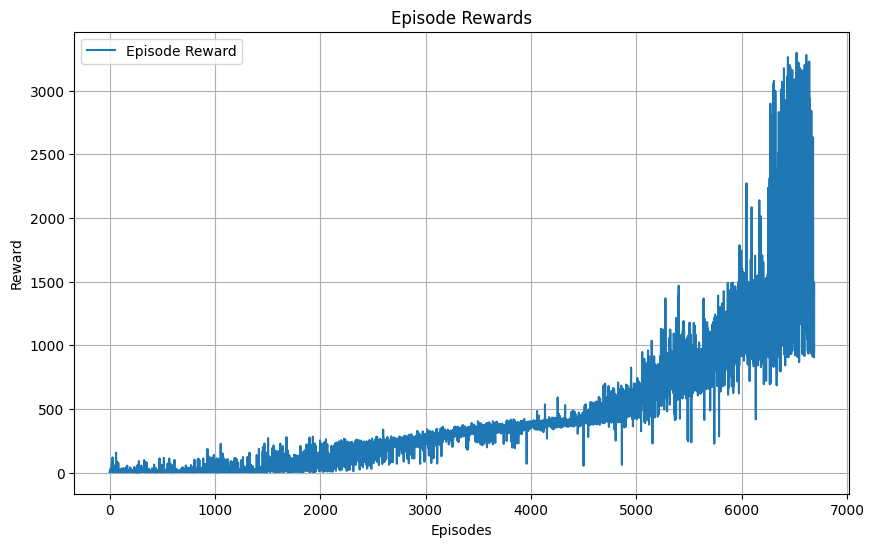

In [114]:
log = pd.read_csv(f"{log_file}.monitor.csv", skiprows=1)  # Skip header comments
plot_reward(log["r"])

In [ ]:
render("Hopper-v5", model)

## Continuous Setup

In [ ]:
import torch

def create_env(log_file, random_mass=False):
    env = make_vec_env(
        "Hopper-v5",
        n_envs=8,
    )
    env = VecMonitor(env, filename=log_file)

    if random_mass:
        body_mass = [
            0., 
            random.uniform(2, 8),
            random.uniform(2, 8),
            random.uniform(2, 8),
            random.uniform(2, 8),
        ]
        print("body mass", body_mass)
        for i in range(env.num_envs):
            # env.envs[i].unwrapped.model.opt.gravity = [0.0, 0.0, gravity]
            # env.envs[i].unwrapped.model.body_mass = [0., 3.66519143, 4.05789051, 2.7813567 , 5.31557477]
            env.envs[i].unwrapped.model.body_mass = body_mass

    return env


def next_gravity(cur):
    while True:
        x = random.uniform(-4, -10)
        if abs(cur - x) >= 3:
            return x


log_file = "hopper"
cur_gravity = -9.81
episode_rewards = []
epoch_end_idx = []
env = create_env(log_file)
model = PPO(
    "MlpPolicy",
    env=env,
    verbose=False,
)

for _ in tqdm(range(3)):
    # print("gravity", cur_gravity)
    model.learn(total_timesteps=250000)
    log = pd.read_csv(f"{log_file}.monitor.csv", skiprows=1)  # Skip header comments
    episode_rewards.extend(log["r"])
    epoch_end_idx.append(len(episode_rewards))

    env.close()
    # cur_gravity = next_gravity(cur_gravity)
    env = create_env(log_file, random_mass=True)
    model.set_env(env)

model.save("ppo.model")


  0%|          | 0/3 [00:00<?, ?it/s]/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
 33%|███▎      | 1/3 [01:17<02:35, 77.51s/it]

body mass [0.0, 3.9517856863732144, 3.604040756251363, 6.087781083385446, 7.030044118647435]


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
 67%|██████▋   | 2/3 [02:40<01:20, 80.64s/it]

body mass [0.0, 7.341310457243347, 7.500707245619954, 6.55725010551179, 7.388457427216073]


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
100%|██████████| 3/3 [04:01<00:00, 80.60s/it]

body mass [0.0, 5.407759162211969, 3.0235495954721996, 2.099266141659787, 7.657184247249406]


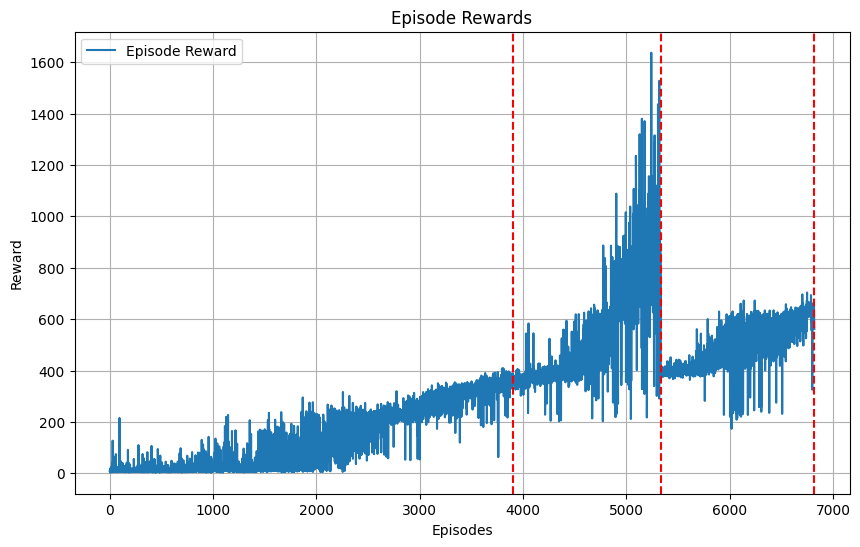

In [75]:
plot_reward(episode_rewards, epoch_end_idx)

In [ ]:
# env = make_vec_env(
#     "Hopper-v5",
#     n_envs=8,
# )
# for i in range(env.num_envs):
#     env.envs[i].unwrapped.model.body_mass = [0., 8.66519143, 1.05789051, 7.7813567 , 3.31557477]

# model.set_env(env)
obs = env.reset()
for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render("human")

In [ ]:
env = make_vec_env("Hopper-v5", n_envs=1)
for i in range(env.num_envs):
    env.envs[i].unwrapped.model.body_mass = [0., 8.66519143, 2.05789051, 2.7813567 , 5.31557477]

m = model.load("ppo.model", env)
obs = env.reset()

for i in range(1000):
    action, _state = m.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render("human")

## Action space

In [117]:
import torch

class ActionPermuteWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.action_size = 3
        self.permutation = list(range(self.action_size))

    def update_permutation(self):
        while True:
            new_permutation = torch.randperm(self.action_size).tolist()
            if new_permutation != self.permutation:
                self.permutation = new_permutation
                print("new action permutation:", self.permutation)
                break

    def step(self, action):
        action = torch.tensor(action)[self.permutation].tolist()
        return self.env.step(action)

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


log_file = "hopper"
env_name = "Hopper-v5"
env = gym.make(env_name)
env = Monitor(env, filename=log_file)
env = ActionPermuteWrapper(env)
model = PPO("MlpPolicy", env=env, verbose=False, policy_kwargs={"net_arch": [32, 32]})
episode_rewards = []
epoch_end_idx = []

for _ in tqdm(range(8)):
    model.learn(total_timesteps=1000000)
    log = pd.read_csv(f"{log_file}.monitor.csv", skiprows=1)  # Skip header comments
    epoch_end_idx.append(len(log["r"]))
    env.update_permutation()

model.save("ppo.model")

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [06:56<48:37, 416.74s/it]

new action permutation: [2, 1, 0]


 25%|██▌       | 2/8 [14:08<42:32, 425.34s/it]

new action permutation: [0, 1, 2]


 38%|███▊      | 3/8 [21:11<35:23, 424.68s/it]

new action permutation: [0, 2, 1]


 50%|█████     | 4/8 [28:12<28:11, 422.87s/it]

new action permutation: [2, 1, 0]


 62%|██████▎   | 5/8 [35:15<21:09, 423.04s/it]

new action permutation: [0, 1, 2]


 75%|███████▌  | 6/8 [42:13<14:02, 421.25s/it]

new action permutation: [0, 2, 1]


 88%|████████▊ | 7/8 [49:18<07:02, 422.49s/it]

new action permutation: [2, 1, 0]


100%|██████████| 8/8 [56:19<00:00, 422.39s/it]

new action permutation: [2, 0, 1]


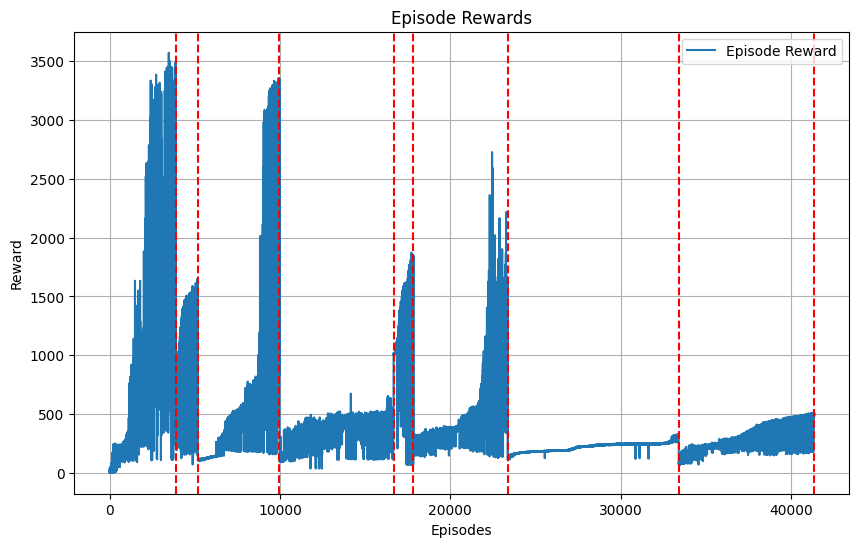

In [120]:
log = pd.read_csv(f"{log_file}.monitor.csv", skiprows=1)  # Skip header comments
plot_reward(log["r"], epoch_end_idx)
# plot_reward(log["r"])